In [1]:
# Set up and load data
# Includes
import sys
import os
import numpy as np
import json
import os


# Setup paths containing utility
curr_folder = os.getcwd()
sys.path.insert(0, os.path.join(curr_folder,'../../../app'))

# Utils imports for loading data
from utils import save_data, load_data, exists_datafolder
from utils import load_SQuAD_train, load_SQuAD_dev
from utils import get_foldername
from utils_NLP import text2sentences,words2words_blanked,words2words_hashblank,words2answers
from utils_NLP import words2text
from utils_SQuAD import OR_arts_paragraph_fields,merge_arts_paragraph_fields
from utils_NLP import allenNLP_classify_blanks,allenNLP_classify_blanks_fromResults

# Plotting includes
from utils_EDAplots import plotbar_train_dev,plothist_train_dev,plotbar_train_dev2,plothist_train_dev2

# Stats saving stuff
from utils_EDA import calcstats_train_dev

# AllenNLP stuff
from allennlp.predictors import Predictor

# Include custom AllenNLP
import myallennlp
from myallennlp import *
from myallennlp.models.simple_tagger2 import SimpleTagger2
from myallennlp.dataset_readers import sequence_tagging2
from myallennlp.data.tokenizers.word_splitter import SpacyWordSplitter

# Import fig stuff
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [2]:
# Option for merging NER data into combined model
merge_in_NER_data = False

# Manually test the predictor

## Load the predictor

In [3]:
# Set up AllenNLP
currmodel = os.path.join('.','model.tar.gz')
predictor = Predictor.from_path(currmodel,predictor_name='sentence-tagger');

02/13/2019 18:08:54 - INFO - allennlp.models.archival -   loading archive file ./model.tar.gz
02/13/2019 18:08:54 - INFO - allennlp.models.archival -   extracting archive file ./model.tar.gz to temp dir /tmp/tmp8964gi30
02/13/2019 18:08:54 - INFO - allennlp.common.params -   type = default
02/13/2019 18:08:54 - INFO - allennlp.data.vocabulary -   Loading token dictionary from /tmp/tmp8964gi30/vocabulary.
02/13/2019 18:08:54 - INFO - allennlp.common.from_params -   instantiating class <class 'allennlp.models.model.Model'> from params {'Ntags0': 93, 'Ntags1': 7, 'do_crossentropy_weighting': True, 'encoder': {'bidirectional': True, 'dropout': 0.5, 'hidden_size': 72, 'input_size': 72, 'num_layers': 2, 'type': 'lstm'}, 'text_field_embedder': {'token_embedders': {'dependency_label': {'embedding_dim': 10, 'type': 'embedding', 'vocab_namespace': 'dependencies'}, 'ner_tag': {'embedding_dim': 7, 'type': 'embedding', 'vocab_namespace': 'ner'}, 'pos_tag': {'embedding_dim': 5, 'type': 'embedding', 

## Run on test sentence

In [35]:
results = predictor.predict(sentence='Pitch is an auditory sensation based on the frequency of vibration.');
words = results['words']
tags = allenNLP_classify_blanks_fromResults(results,'0')
out = words_blanked_allen = words2words_hashblank(words,tags)
print(out)

['___Pitch___', 'is', 'an', 'auditory', 'sensation', 'based', 'on', 'the', 'frequency', 'of', '___vibration___', '.']


In [36]:
results = predictor.predict(sentence='The French are from northern France.');
words = results['words']
tags = allenNLP_classify_blanks_fromResults(results,'0')
out = words_blanked_allen = words2words_hashblank(words,tags)
print(out)

['The', 'French', 'are', 'from', 'northern', 'France', '.']


In [37]:
results = predictor.predict(sentence='The brain is an organ that serves as the center of the nervous system in all vertebrate and most invertebrate animals.');
words = results['words']
tags = allenNLP_classify_blanks_fromResults(results,'0')
out = words_blanked_allen = words2words_hashblank(words,tags)
print(out)

['The', 'brain', 'is', 'an', '___organ___', 'that', 'serves', 'as', 'the', 'center', 'of', 'the', 'nervous', 'system', 'in', 'all', '___vertebrate___', 'and', 'most', '___invertebrate___', 'animals', '.']


In [40]:
results = predictor.predict(sentence='Physiologically, the function of the brain is to exert centralized control over the other organs of the body.');
words = results['words']
tags = allenNLP_classify_blanks_fromResults(results,'0')
out = words_blanked_allen = words2words_blanked(words,tags)
print(out)

['______', ',', 'the', 'function', 'of', 'the', '______', 'is', 'to', 'exert', 'centralized', 'control', 'over', 'the', 'other', 'organs', 'of', 'the', 'body', '.']


In [43]:
results = predictor.predict(sentence='The Black Death ravaged Europe for three years before it continued on into Russia, where the disease was present somewhere in the country 25 times between 1350 to 1490.');
words = results['words']
tags = allenNLP_classify_blanks_fromResults(results,'0')
out = words_blanked_allen = words2words_blanked(words,tags)
print(out)

['The', '______', 'Death', 'ravaged', 'Europe', 'for', 'three', 'years', 'before', 'it', 'continued', 'on', 'into', '______', ',', 'where', 'the', '______', 'was', 'present', 'somewhere', 'in', 'the', 'country', '25', 'times', 'between', '______', 'to', '______', '.']


In [44]:
results = predictor.predict(sentence='The Black Death ravaged Europe for three years before it continued on into Russia.');
words = results['words']
tags = allenNLP_classify_blanks_fromResults(results,'0')
out = words_blanked_allen = words2words_blanked(words,tags)
print(out)

['The', '______', 'Death', 'ravaged', 'Europe', 'for', 'three', 'years', 'before', 'it', 'continued', 'on', 'into', 'Russia', '.']


In [63]:
results = predictor.predict(sentence='I continued on into Russia, which is a country.');
words = results['words']
tags = allenNLP_classify_blanks_fromResults(results,'0')
out = words_blanked_allen = words2words_blanked(words,tags)
print(out)

['I', 'continued', 'on', 'into', '______', ',', 'which', 'is', 'a', 'country', '.']


In [65]:
results = predictor.predict(sentence='I continued on into Russia, which is a food.');
words = results['words']
tags = allenNLP_classify_blanks_fromResults(results,'0')
out = words_blanked_allen = words2words_blanked(words,tags)
print(out)

['I', 'continued', 'on', 'into', 'Russia', ',', 'which', 'is', 'a', 'food', '.']


In [81]:
results = predictor.predict(sentence='Moscow is the capital of Russia.');
words = results['words']
tags = allenNLP_classify_blanks_fromResults(results,'0')
out = words_blanked_allen = words2words_blanked(words,tags)
print(out)

['______', 'is', 'the', 'capital', 'of', 'Russia', '.']


In [167]:
results = predictor.predict(sentence='Manchester is the capital of England.');
words = results['words']
tags = allenNLP_classify_blanks_fromResults(results,'0')
out = words_blanked_allen = words2words_blanked(words,tags)
print(out)

['Manchester', 'is', 'the', 'capital', 'of', '______', '.']


In [162]:
results = predictor.predict(sentence='Washington is the capital of England.');
words = results['words']
tags = allenNLP_classify_blanks_fromResults(results,'0')
out = words_blanked_allen = words2words_blanked(words,tags)
print(out)

['______', 'is', 'the', 'capital', 'of', 'England', '.']


In [ ]:
# Pull out sample paragraph
p = arts[ind_ex_dev]['paragraphs'][0]

# # Print all AllenNLP classifications
# print([(a,b) for a,b in zip(p['allenNER']['words'].split(), p['allenNER']['tags'].split())])

# AllenNLP results
words = p['allenNER']['words'].split()
# tags = p['allenNER']['tags'].split()
# tags = [not t == '0' for t in tags]   # Convert to binary
tags = p['blank_classified_allen']

# Ground truth
blank_classification = p['blank_classification']


words_blanked_ground_truth = words2words_blanked(words,blank_classification)
words_blanked_allen = words2words_blanked(words,tags)


# Load and merge ground truth and MODEL data

In [3]:
!pwd

/home/davestanley/Dropbox/git/mindpocket/train_model/articles_batch2.0/entropy_93_07_model6e0c37


In [11]:
# Load data containing MODEL (predictions)
foldername = os.path.join('SQ_pp_b4m0c2')
arts_train = load_data('train.json',foldername,prepend_data_folder=False)
arts_dev = load_data('dev.json',foldername,prepend_data_folder=False)

# All articles
Ntrain = len(arts_train)
Ndev = len(arts_dev)

arts = arts_train + arts_dev
print(arts[1]['title'])
# print(arts[1]['paragraphs'][0]['context'])

Frédéric_Chopin


In [17]:
arts[0]['paragraphs'][0].keys()

dict_keys(['qas', 'context', 'allenNER'])

In [5]:
# Trim down newly loaded articles to match Narticles in training set
ind_train = slice(0,Ntrain)
ind_dev = slice(0,Ndev)

# Chosen display articles
ind_ex_train = 1                   # Example from training set - Chopin
ind_ex_dev = Ntrain + (467-442)    # Example from dev set - Immune system
ind_ex_dev = Ntrain + (458-442)    # Example from dev set - Pharmacy
ind_ex_dev = Ntrain + (456-442)    # Example from dev set - Black death
# ind_ex_dev = 105                   # Pitch

In [6]:
# Load blanks data (ground truth)
foldername = get_foldername('sq_pp_training')
arts3 = load_data('train.json',foldername)[ind_train] + load_data('dev.json',foldername)[ind_dev]
print(arts3[1]['title'])
# print(arts3[1]['paragraphs'][0]['context_blanked'])


Frédéric_Chopin


In [7]:
# Make sure all titles match
all_title_pairs = [(a1['title'],a3['title']) for a1,a3 in zip(arts,arts3)]
titles_match_bool = [a1['title'] == a3['title'] for a1,a3 in zip(arts,arts3)]
print("Matching titles: {} \nTotal articles {}".format(sum(titles_match_bool),len(titles_match_bool)))
if not sum(titles_match_bool) == len(titles_match_bool):
    raise ValueError('Articles mismatch.')


Matching titles: 55 
Total articles 55


In [8]:
# Merge ground truth blanks with original data to get full dataset
list_of_fields = ['context_blanked','blank_classification']
arts = merge_arts_paragraph_fields(arts,arts3,list_of_fields)

# print(arts[1]['title'])
# print(arts[1]['paragraphs'][0]['context'])
# print(arts[1]['paragraphs'][0]['context_blanked'])

In [9]:
arts[ind_ex_train]['paragraphs'][0]['context']

'Frédéric François Chopin (/ˈʃoʊpæn/; French pronunciation: \u200b[fʁe.de.ʁik fʁɑ̃.swa ʃɔ.pɛ̃]; 22 February or 1 March 1810 – 17 October 1849), born Fryderyk Franciszek Chopin,[n 1] was a Polish and French (by citizenship and birth of father) composer and a virtuoso pianist of the Romantic era, who wrote primarily for the solo piano. He gained and has maintained renown worldwide as one of the leading musicians of his era, whose "poetic genius was based on a professional technique that was without equal in his generation." Chopin was born in what was then the Duchy of Warsaw, and grew up in Warsaw, which after 1815 became part of Congress Poland. A child prodigy, he completed his musical education and composed his earlier works in Warsaw before leaving Poland at the age of 20, less than a month before the outbreak of the November 1830 Uprising.'

In [10]:
# Convert AllenNLP Model blanks classification into standard format

# If doing merge, use unique name for this model result. Otherwise, use generic name
if merge_in_NER_data: fieldname = 'blank_classified_allenMODEL'
else: fieldname = 'blank_classified_allen'

arts = allenNLP_classify_blanks(arts,'0',fieldname)
arts[0]['paragraphs'][0].keys()

dict_keys(['qas', 'context', 'allenNER', 'context_blanked', 'blank_classification', 'blank_classified_allen'])

# Load NER data and merge into arts dataset

In [11]:

if merge_in_NER_data:
    # Load data containing NEP (predictions)
    foldername = get_foldername('sq_pp_ner')

    arts_NER = load_data('train.json',foldername)[ind_train] + load_data('dev.json',foldername)[ind_dev]
    print(arts[1]['title'])
    # print(arts[1]['paragraphs'][0]['context'])

    # Make sure all titles match
    all_title_pairs = [(a1['title'],a3['title']) for a1,a3 in zip(arts,arts_NER)]
    titles_match_bool = [a1['title'] == a3['title'] for a1,a3 in zip(arts,arts_NER)]
    print("Matching titles: {} \nTotal articles {}".format(sum(titles_match_bool),len(titles_match_bool)))
    if not sum(titles_match_bool) == len(titles_match_bool):
        raise ValueError('Articles mismatch.')

    # Convert AllenNLP Model blanks classification into standard format
    from utils_NLP import allenNLP_classify_blanks
    arts_NER = allenNLP_classify_blanks(arts_NER,'O','blank_classified_allenNER')
    print(arts_NER[0]['paragraphs'][0].keys())

    # Merge NER data into full dataset
    list_of_fields = ['blank_classified_allenNER']
    arts = merge_arts_paragraph_fields(arts,arts_NER,list_of_fields)
    print(arts[0]['paragraphs'][0].keys())

In [12]:
# OR operation on blank_classified_allenMODEL and blank_classified_allenNER into blank_classified_allenMODEL

if merge_in_NER_data:
    destination_fieldname = 'blank_classified_allen'
    arts = OR_arts_paragraph_fields(arts,['blank_classified_allenMODEL','blank_classified_allenNER'],destination_fieldname)

    p = arts[0]['paragraphs'][1]
    print(p['blank_classified_allenNER'])
    print(p['blank_classified_allenMODEL'])
    print(p['blank_classified_allen'])


# Compare paragraph word reconstructions

This just looks at the words in the different saved fiels files to make sure all the words match up 1:1 (otherwise, this could mess up our evaluations). Not looking at blanks here at all. The next sectoin looks at the blanks

In [13]:
# Pull out sample paragraph
p = arts[ind_ex_dev]['paragraphs'][0]

## AllenNLP Words

In [14]:
words = p['allenNER']['words'].split()
tags = p['allenNER']['tags'].split()
print(len(words))
print(len(tags))
print(words2text(words))
print(len(words2text(words)))

131
131
The Black Death is thought to have originated in the arid plains of Central Asia, where it then travelled along the Silk Road, reaching Crimea by 1343. From there, it was most likely carried by Oriental rat fleas living on the black rats that were regular passengers on merchant ships. Spreading throughout the Mediterranean and Europe, the Black Death is estimated to have killed 30–60 % of Europe 's total population. In total, the plague reduced the world population from an estimated 450 million down to 350–375 million in the 14th century. The world population as a whole did not recover to pre - plague levels until the 17th century. The plague recurred occasionally in Europe until the 19th century.
706


## Context

In [15]:
from utils_NLP import allenNLP_split_words, join_punctuation

context = p['context']
context_split = allenNLP_split_words(context)

# context_reassembled = ' '.join(context_split)
context_reassembled = words2text(context_split)

print(len(context_split))
# print(words2text(context_split))
# print(len(words2text(context_split)))
print(context_reassembled)
print(len(context_reassembled))


131
The Black Death is thought to have originated in the arid plains of Central Asia, where it then travelled along the Silk Road, reaching Crimea by 1343. From there, it was most likely carried by Oriental rat fleas living on the black rats that were regular passengers on merchant ships. Spreading throughout the Mediterranean and Europe, the Black Death is estimated to have killed 30–60 % of Europe 's total population. In total, the plague reduced the world population from an estimated 450 million down to 350–375 million in the 14th century. The world population as a whole did not recover to pre - plague levels until the 17th century. The plague recurred occasionally in Europe until the 19th century.
706


## Context_blanked

In [16]:
print(len(p['blank_classification']))
print(p.keys())
print(p['context_blanked'])

131
dict_keys(['qas', 'context', 'allenNER', 'context_blanked', 'blank_classification', 'blank_classified_allen'])
The Black Death is thought to have originated in the arid plains of ______ ______ , where it then travelled along the ______ ______ , reaching Crimea by 1343 . From there , it was most likely carried by Oriental rat fleas living on the black rats that were regular passengers on ______ ______ . Spreading throughout the Mediterranean and Europe , the Black Death is estimated to have killed 30–60 % of Europe 's total population . In total , the plague reduced the world population from an estimated 450 million down to 350–375 million in the 14th ______ . The world population as a whole did not recover to pre - plague levels until the ______ ______ . The plague recurred occasionally in Europe until the ______ ______ .


In [17]:
# Answers
for i,c in enumerate(p['blank_classification']):
    if c == 1: print(context_split[i])

Central
Asia
Silk
Road
merchant
ships
century
17th
century
19th
century


# Single paragraph - Compare blanks

## First, just look at the raw text

In [18]:
# Pull out sample paragraph
p = arts[ind_ex_dev]['paragraphs'][0]

# # Print all AllenNLP classifications
# print([(a,b) for a,b in zip(p['allenNER']['words'].split(), p['allenNER']['tags'].split())])

# AllenNLP results
words = p['allenNER']['words'].split()
# tags = p['allenNER']['tags'].split()
# tags = [not t == '0' for t in tags]   # Convert to binary
tags = p['blank_classified_allen']

# Ground truth
blank_classification = p['blank_classification']

In [19]:


print("Length Allen tags: {}. Length ground truth blanks: {}".format(len(tags),len(blank_classification)))

Length Allen tags: 131. Length ground truth blanks: 131


In [20]:
# Side by side compare

words_blanked_ground_truth = words2words_blanked(words,blank_classification)
words_blanked_allen = words2words_blanked(words,tags)

N=len(words_blanked_ground_truth)
N=20
print("============" + '\t\t\t' + "==========")
print("Ground truth" + '\t\t\t' + "Prediction")
print("============" + '\t\t\t' + "==========")
for c,w in zip(words_blanked_ground_truth[:N],words_blanked_allen[:N]):
    print(c + '\t\t\t\t' + w)


============			==========
Ground truth			Prediction
============			==========
The				The
Black				______
Death				______
is				is
thought				thought
to				to
have				have
originated				originated
in				in
the				the
arid				arid
plains				______
of				of
______				______
______				Asia
,				,
where				where
it				it
then				then
travelled				travelled


## Ground truth blanked

In [21]:
# Blanked text
print(words2text(words_blanked_ground_truth))

# Answers    
myanswers = words2answers(words,blank_classification)
print("Answers:")
print(myanswers)

The Black Death is thought to have originated in the arid plains of ______ ______, where it then travelled along the ______ ______, reaching Crimea by 1343. From there, it was most likely carried by Oriental rat fleas living on the black rats that were regular passengers on ______ ______. Spreading throughout the Mediterranean and Europe, the Black Death is estimated to have killed 30–60 % of Europe 's total population. In total, the plague reduced the world population from an estimated 450 million down to 350–375 million in the 14th ______. The world population as a whole did not recover to pre - plague levels until the ______ ______. The plague recurred occasionally in Europe until the ______ ______.
Answers:
['Central', 'Asia', 'Silk', 'Road', 'merchant', 'ships', 'century', '17th', 'century', '19th', 'century']


In [22]:
# Blanked text
print(words2text(words_blanked_allen))

# Answers    
myanswers = words2answers(words,tags)
print("Answers:")
print(myanswers)

The ______ ______ is thought to have originated in the arid ______ of ______ Asia, where it then travelled along the ______ ______, reaching Crimea by ______. From there, it was most likely carried by ______ ______ ______ living on the black ______ that were regular passengers on merchant ships. Spreading throughout the ______ and Europe, the ______ ______ is estimated to have killed ______ % of Europe 's total population. In total, the ______ reduced the world population from an estimated ______ ______ down to 350–375 ______ in the 14th century. The world population as a whole did not recover to pre - plague levels until the ______ century. The ______ recurred occasionally in Europe until the 19th century.
Answers:
['Black', 'Death', 'plains', 'Central', 'Silk', 'Road', '1343', 'Oriental', 'rat', 'fleas', 'rats', 'Mediterranean', 'Black', 'Death', '30–60', 'plague', '450', 'million', 'million', '17th', 'plague']


In [23]:
TP = sum([b and t for b,t in zip(blank_classification,tags)])
FP = sum([not b and t for b,t in zip(blank_classification,tags)])
FN = sum([b and not t for b,t in zip(blank_classification,tags)])
TN = sum([not b and not t for b,t in zip(blank_classification,tags)])
ACC = (TP+TN)/(TP+FP+FN+TN)
ACC2 = sum([b == t for b,t in zip(blank_classification,tags)]) / len(tags)

In [24]:
print(ACC)
print(ACC2)
print(TP)
print(FP)

0.816793893129771
0.816793893129771
4
17


In [25]:
# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)


In [26]:
print(TPR)
print(FPR)

0.36363636363636365
0.14166666666666666


In [27]:
Nsentences = len(text2sentences(p['context']))
print("Nsentences={}".format(str(Nsentences)))

Nsentences2 = len(text2sentences(words2text(words)))
print("Nsentences_from_words={}".format(str(Nsentences2)))



Nsentences=6
Nsentences_from_words=6


In [28]:
TPpersent = TP / Nsentences2
FPpersent = FP / Nsentences2

print(TPpersent)
print(FPpersent)

0.6666666666666666
2.8333333333333335


# Single article - compare blanks

In [29]:
##### Pull out sample paragraph
a = arts[ind_ex_dev]
print(a['title'])

# AllenNLP results
words = [w for p in a['paragraphs'] for w in p['allenNER']['words'].split()]
# tags = [t for p in a['paragraphs'] for t in p['allenNER']['tags'].split()]
# tags = [not t == '0' for t in tags]   # Convert to binary
tags = [t for p in a['paragraphs'] for t in p['blank_classified_allen']]

# Ground truth
blank_classification = [bc for p in a['paragraphs'] for bc in p['blank_classification']]

Black_Death


In [30]:

print("Length Allen tags: {}. Length ground truth blanks: {}".format(len(tags),len(blank_classification)))

Length Allen tags: 3683. Length ground truth blanks: 3683


In [31]:
# Side by side compare
words_blanked_ground_truth = words2words_blanked(words,blank_classification)
words_blanked_allen = words2words_blanked(words,tags)

N=len(words_blanked_ground_truth)
N=30
print("========" + '\t\t\t' + "============" + '\t\t\t' + "==========")
print("Original" + '\t\t\t' + "Ground truth" + '\t\t\t' + "Prediction")
print("========" + '\t\t\t' + "============" + '\t\t\t' + "==========")
for o,c,w in zip(words[:N],words_blanked_ground_truth[:N],words_blanked_allen[:N]):
    print(o + '\t\t\t\t' + c + '\t\t\t\t' + w)


========			============			==========
Original			Ground truth			Prediction
========			============			==========
The				The				The
Black				Black				______
Death				Death				______
is				is				is
thought				thought				thought
to				to				to
have				have				have
originated				originated				originated
in				in				in
the				the				the
arid				arid				arid
plains				plains				______
of				of				of
Central				______				______
Asia				______				Asia
,				,				,
where				where				where
it				it				it
then				then				then
travelled				travelled				travelled
along				along				along
the				the				the
Silk				______				______
Road				______				______
,				,				,
reaching				reaching				reaching
Crimea				Crimea				Crimea
by				by				by
1343				1343				______
.				.				.


In [32]:
TP = sum([b and t for b,t in zip(blank_classification,tags)])
FP = sum([not b and t for b,t in zip(blank_classification,tags)])
FN = sum([b and not t for b,t in zip(blank_classification,tags)])
TN = sum([not b and not t for b,t in zip(blank_classification,tags)])
ACC = (TP+TN)/(TP+FP+FN+TN)
ACC2 = sum([b == t for b,t in zip(blank_classification,tags)]) / len(tags)

In [33]:
print(ACC)
print(ACC2)

0.8373608471354874
0.8373608471354874


In [34]:
# # Sensitivity, hit rate, recall, or true positive rate
# TPR = TP/(TP+FN)
# # Specificity or true negative rate
# TNR = TN/(TN+FP) 
# # Precision or positive predictive value
# PPV = TP/(TP+FP)
# # Negative predictive value
# NPV = TN/(TN+FN)
# # Fall out or false positive rate
# FPR = FP/(FP+TN)
# # False negative rate
# FNR = FN/(TP+FN)
# # False discovery rate
# FDR = FP/(TP+FP)


In [35]:
# print(TPR)
# print(FPR)

In [36]:
Nsentences2 = len(text2sentences(words2text(words)))
print("Nsentences_from_words={}".format(str(Nsentences2)))

Nsentences_from_words=126


In [37]:
TPpersent = TP / Nsentences2
FPpersent = FP / Nsentences2

print(TPpersent)
print(FPpersent)

0.7142857142857143
4.182539682539683


## Ground truth blanked vs predicted blanked

In [38]:
# Blanked text
# print(words2text(words_blanked_ground_truth))

# Answers    
myanswers = words2answers(words,blank_classification)
print("Answers:")
print(set(myanswers))

Answers:
{'Silk', '1850', 'Jani', 'Smithfield', 'Alexandre', '1654', 'faster', 'Asia', 'bad', '90', 'ships', '38–41', 'century', 'corpses', 'Italian', 'atra', 'bubonic', '1350', '1.7', '1823', 'Scandinavia', 'northwestern', '1500', 'Genoese', 'significance', 'J.I.', 'dating', 'fleas', 'Miasma', '1908', 'Kong', 'France', '15', 'rats', 'trade', 'China', 'Half', 'plague', '2010', 'commonly', '1338–39', 'Justinian', 'East', 'much', 'England', 'Germany', 'theory', 'million', '1665', 'Yersin', 'percent', '2011', 'Yersinia', 'merchant', '100–106', 'anthrax', '100,000', '19th', 'infected', 'traders', '95', 'Gasquet', 'half', 'king', 'pestis', 'areas', 'branches', '40,000', 'Hong', 'Plague', '1331', '1720', 'Beg', 'marginal', 'Pontanus', '1349', 'isolated', 'form', 'amended', 'Road', 'genetic', 'October', 'Y.', 'present', 'Sicily', '1377', 'figures', 'mors', 'north', '22', 'clergy', 'air', '25', 'Central', '5', 'account', 'Russia', 'Constantinople', 'population', 'autumn', 'northwest', 'epidemi

In [39]:
# Blanked text
# print(words2text(words_blanked_allen))

# Answers    
myanswers = words2answers(words,tags)
print("Answers:")
print(set(myanswers))

Answers:
{'Silk', 'CE', 'Sloane', '7', 'infectious', 'clades', '1850', 'society', 'Jani', 'Portugal', 'Basque', 'Mongol', 'outbreaks', 'India', 'Alexandre', 'malaise', 'Smithfield', 'Epidemics', 'Cohn', 'symptoms', 'Monks', '1576–77', '1654', '1620–21', '30–75', 'Lake', '1374', 'bites', 'pandemics', '700', 'spaced', 'Haensch', 'infections', '1593', 'Helsinki', 'Pneumonic', 'corpses', 'Italian', 'atra', 'Italy', 'bubonic', '1389–93', '1350', 'Biraben', '1.7', 'Bergen', 'disease', '1823', 'endemic', 'Minor.[citation', 'Scandinavia', '1500', 'Homs', 'Genoese', 'Domesday', '1750', 'Middle', 'buboes', 'Zoom', 'Amsterdam', 'J.I.', 'Archaeologist', 'resistant', '1893', 'Mediterranean', 'fleas', 'Miasma', 'Aleppo', 'Norway', 'rat', '50', '1908', '300,000', 'coagulation', 'France', '15', 'Nestorian', 'skin', 'rats', 'Geoffrey', 'respiratory', 'behaviour', 'epidemics', 'Netherlands', 'China', 'purpura', 'wills', 'Kaffa', 'starvation', 'Londoners', 'pits', 'plague', 'Pandemic', '1490', '450', '16

## Fract of answers blanked

### Fract answers blanked vs num answers

In [40]:

# Pseudocode
# For each answer, loop through the words and count the number of times it occurs.
# Get the set of blanks booleans associated with each occurrence of that words, and calculate the
# mean. Will do this for each word in the article, and then each article in the corpus. For each
# article, rank the words by their proximity to 50 % 

myanswers_unique = list(set(words2answers(words,tags)))

fracblanked = []
numblanked = []
for ans in myanswers_unique:
    indices = [i for i, w in enumerate(words) if w == ans]
    tags_curr = [tags[i] for i in indices]
    #words_curr = [words[i] for i in indices]
    fracblanked.append(sum(tags_curr)/len(tags_curr)*100)
    numblanked.append(len(tags_curr))

Text(0, 0.5, 'Num occurrences')

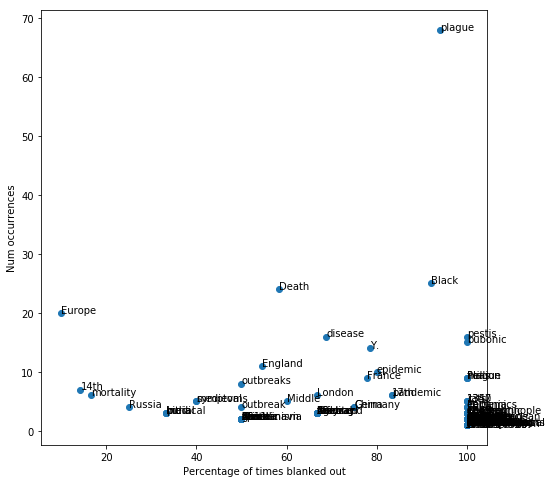

In [41]:
# Do scatter plot
y = numblanked
z = fracblanked
n = myanswers_unique

fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(z, y)

for i, txt in enumerate(n):
    ax.annotate(txt, (z[i], y[i]))
plt.xlabel('Percentage of times blanked out')
plt.ylabel('Num occurrences')

### Fract answers blanked for all answers

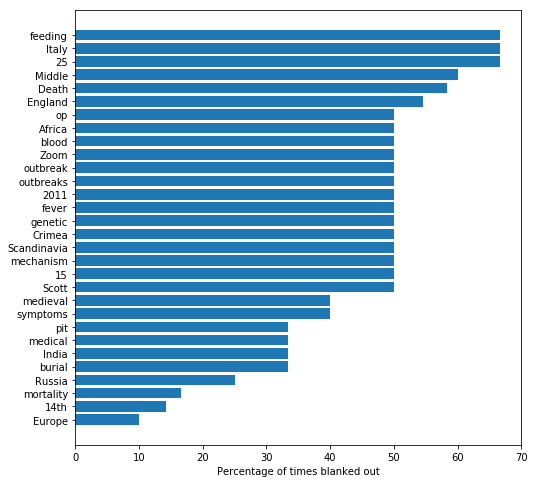

In [42]:
import numpy as np
import pandas as pd

d = {'myanswers_unique':myanswers_unique,'fracblanked':fracblanked}

df = pd.DataFrame(data=d);

df2 = df.sort_values(by='fracblanked',ascending=True);



N=30          # of data points to show
figure(num=None, figsize=(8, 8),facecolor='w', edgecolor='k')
bars = (df2['myanswers_unique'].values.tolist())[0:N]
y_pos = np.arange(len(bars))
val = (df2['fracblanked'].values.tolist())[0:N]
y_pos = np.arange(len(bars))
 
# Create horizontal bars
plt.barh(y_pos, val)
 
# Create names on the y-axis
plt.yticks(y_pos, bars)

plt.xlabel('Percentage of times blanked out')
# Show graphic
plt.show()



### Fractions of POS/NER tags blanked

In [43]:
import spacy

nlp = spacy.load('en_core_web_sm')
doc = nlp(words2text(words))

pos=[]
ner=[]
dep=[]
for token in doc:
    pos.append(token.pos_)
    ner.append(token.ent_type_)
    dep.append(token.dep_)

# Build a dataframe to store everything
d = {'ind': range(len(words)),
     'words' : words,
    'tags':tags,
    'pos':pos,
    'ner':ner,
    'dep':dep}

df = pd.DataFrame(data=d)

xlabs=[]
yvals=[]

# Search through keys and unique items therein, counting "Trues"
keys = ['ner']
for k in keys:
    for item in list(set(d[k])):
        df2 = df.loc[df[k] == item]
        mysum = df2.sum()['tags']
        N = len(df2)
        
        xlabs.append(k.upper() + ': ' + item.lower())
        yvals.append(mysum/N*100)

        


ValueError: arrays must all be same length

In [ ]:
df3 = df.loc[df['ner'] == 'PERSON']
df3           # Hmmm

In [ ]:
df = pd.DataFrame(data={'xlabs':xlabs,'yvals':yvals})
df = df.sort_values(by='yvals',ascending=True)
df

In [ ]:
figure(num=None, figsize=(7,7),facecolor='w', edgecolor='k')
bars = df['xlabs']
y_pos = np.arange(len(bars))
val = df['yvals']

# Make fake dataset
y_pos = np.arange(len(bars))
 
# Create horizontal bars
plt.barh(y_pos, val)
 
# Create names on the y-axis
plt.yticks(y_pos, bars)

plt.xlabel('% of times blanked')
# Show graphic
plt.show()


## Whole article

### Ground truth

In [44]:

# print('--------------- GROUND TRUTH ---------------')

# # Pull out sample paragraph
# for p in arts[ind_ex_dev]['paragraphs']:
#     # # Print all AllenNLP classifications
#     # print([(a,b) for a,b in zip(p['allenNER']['words'].split(), p['allenNER']['tags'].split())])

#     # AllenNLP results
#     words = p['allenNER']['words'].split()
#     # tags = p['allenNER']['tags'].split()
#     # tags = [not t == '0' for t in tags]   # Convert to binary
#     tags = p['blank_classified_allen']

#     # Ground truth
#     blank_classification = p['blank_classification']

#     words_blanked_ground_truth = words2words_blanked(words,blank_classification)
#     words_blanked_allen = words2words_blanked(words,tags)
#     words_hash_ground_truth = words2words_hashblank(words,blank_classification)
#     words_hash_allen = words2words_hashblank(words,tags)
    
    
#     # Blanked text
#     print(words2text(words_hash_ground_truth))

#     # Answers    
#     myanswers = words2answers(words,blank_classification)
#     print("Answers:")
#     print(myanswers)

    

### My model

In [45]:

print('--------------- MY MODEL ---------------')
# Pull out sample paragraph
for p in arts[ind_ex_dev]['paragraphs']:
    # # Print all AllenNLP classifications
    # print([(a,b) for a,b in zip(p['allenNER']['words'].split(), p['allenNER']['tags'].split())])

    # AllenNLP results
    words = p['allenNER']['words'].split()
    # tags = p['allenNER']['tags'].split()
    # tags = [not t == '0' for t in tags]   # Convert to binary
    tags = p['blank_classified_allen']

    # Ground truth
    blank_classification = p['blank_classification']

    words_blanked_ground_truth = words2words_blanked(words,blank_classification)
    words_blanked_allen = words2words_blanked(words,tags)
    words_hash_ground_truth = words2words_hashblank(words,blank_classification)
    words_hash_allen = words2words_hashblank(words,tags)
    
    # Blanked text
    print(words2text(words_hash_allen))

    # Answers    
    myanswers = list(set(words2answers(words,tags)))
    print("Answers:")
    print(myanswers)
    

    

--------------- MY MODEL ---------------
The ___Black___ ___Death___ is thought to have originated in the arid ___plains___ of ___Central___ Asia, where it then travelled along the ___Silk___ ___Road___, reaching Crimea by ___1343___. From there, it was most likely carried by ___Oriental___ ___rat___ ___fleas___ living on the black ___rats___ that were regular passengers on merchant ships. Spreading throughout the ___Mediterranean___ and Europe, the ___Black___ ___Death___ is estimated to have killed ___30–60___ % of Europe 's total population. In total, the ___plague___ reduced the world population from an estimated ___450___ ___million___ down to 350–375 ___million___ in the 14th century. The world population as a whole did not recover to pre - plague levels until the ___17th___ century. The ___plague___ recurred occasionally in Europe until the 19th century.
Answers:
['Death', 'million', '30–60', 'Silk', 'Black', 'Road', 'Oriental', 'plains', 'rats', '450', 'Central', 'Mediterranean

# All articles - compare blanks

In [ ]:
# Initialize stuff
TPR0 = []
FPR0 = []
ACC0 = []
Nsentences0 = []
TP0 = []
FP0 = []
FN0 = []
TN0 = []
TPpersent0 = []
FPpersent0 = []
abads = []            # Article-level bads
sbc0 = []
st0 = []
Nwords0 = []

art = arts[:]

i=-1
for a in art:
    i=i+1
    # AllenNLP results
    words = [w for p in a['paragraphs'] for w in p['allenNER']['words'].split()]
#     tags = [t for p in a['paragraphs'] for t in p['allenNER']['tags'].split()]
#     tags = [not t == '0' for t in tags]   # Convert to binary
    tags = [t for p in a['paragraphs'] for t in p['blank_classified_allen']]

    # Ground truth
    blank_classification = [bc for p in a['paragraphs'] for bc in p['blank_classification']]
    blank_classification = [b == 1 for b in blank_classification] # Convert to binary

    Nsentences2 = len(text2sentences(words2text(words)))

    sbc = sum(blank_classification)
    st = sum(tags)
    if sbc == 0 or st == 0:
        print("Warning article {} contains {} ground truth blanks and {} tags. Likely bad".format(str(i),str(sbc),str(st)))

        # Make up some dummy values so don't confuse for a REAL outlier in plots. Should just drop this data in the future
        # This is ok because we'll skip them later if want to do stats - that's what abads is for
        TPR = 0.0
        FPR = 0.0
        ACC = 0.0
        TP = 100
        FP = 100
        FN = 100
        TN = 100

        TPpersent = 1
        FPpersent = 1
        abads.append(i)
    else:
        TP = sum([b and t for b,t in zip(blank_classification,tags)])
        FP = sum([not b and t for b,t in zip(blank_classification,tags)])
        FN = sum([b and not t for b,t in zip(blank_classification,tags)])
        TN = sum([not b and not t for b,t in zip(blank_classification,tags)])
        ACC = (TP+TN)/(TP+FP+FN+TN)
        ACC2 = sum([b == t for b,t in zip(blank_classification,tags)]) / len(tags)

        # Sensitivity, hit rate, recall, or true positive rate
        TPR = TP/(TP+FN)
        # Specificity or true negative rate
        TNR = TN/(TN+FP)
        # Precision or positive predictive value
        PPV = TP/(TP+FP)
        # Negative predictive value
        NPV = TN/(TN+FN)
        # Fall out or false positive rate
        FPR = FP/(FP+TN)
        # False negative rate
        FNR = FN/(TP+FN)
        # False discovery rate
        FDR = FP/(TP+FP)

        # Per sententance values
        TPpersent = TP / Nsentences2
        FPpersent = FP / Nsentences2

    TPR0.append(TPR)
    FPR0.append(FPR)
    ACC0.append(ACC)
    TP0.append(TP)
    FP0.append(FP)
    FN0.append(FN)
    TN0.append(TN)
    TPpersent0.append(TPpersent)
    FPpersent0.append(FPpersent)
    sbc0.append(sbc)
    st0.append(st)
    Nwords0.append(len(tags))

In [ ]:
# Print tiles of bad articles
for ab in abads:
    print(art[ab]['title'])

In [ ]:
# Calculate how this affects Ntrain / Ndev
Ntrain_bad = len([b for b in abads if b < Ntrain])
Ndev_bad = len([b for b in abads if b >= Ntrain])
print('Ntrain={}'.format(str(Ntrain)))
print('Ndev={}'.format(str(Ndev)))
print('Ntrain_bad={}'.format(str(Ntrain_bad)))
print('Ndev_bad={}'.format(str(Ndev_bad)))




## Plot TPR

In [ ]:
myvar = TPR0
varname = 'TPR'

# Plot bargraph
plotbar_train_dev2(myvar,Ntrain,Ndev,ylabel='{} per article'.format(varname),xlabel='Article #')

# # # Plot the histogram without containing any bads
# myvar without the bad articles
myvar2 = [tp for i, tp in enumerate(myvar) if i not in abads]

# Plot the histogram
ax = plothist_train_dev2(myvar2,Ntrain-Ntrain_bad,Ndev-Ndev_bad,xlabel=varname,ylabel='N Articles',devbins='auto')
set(ax['ax1'].set_xlim(0,1));
set(ax['ax2'].set_xlim(0,1));



## Plot FPR

In [ ]:
myvar = FPR0
varname = 'FPR'

# Plot bargraph
plotbar_train_dev2(myvar,Ntrain,Ndev,ylabel='{} per article'.format(varname),xlabel='Article #')

# # # Plot the histogram without containing any bads
# myvar without the bad articles
myvar2 = [tp for i, tp in enumerate(myvar) if i not in abads]

# REdefine for plotting with with more decimal places
def plothist_train_dev2(myvar,Ntrain,Ndev,xlabel='value',ylabel='N Articles',devbins=30):
    # Import fig stuff
    import matplotlib.pyplot as plt
    from matplotlib.pyplot import figure
    import statistics

    f, (ax1, ax2) = plt.subplots(1, 2, sharey=False,figsize=(15, 4));
    ax1.hist(myvar[0:Ntrain-1], bins=30);  # arguments are passed to np.histogram
    ax1.set_title("Narticles={}, median={}, mean={}".format(str(Ntrain),'{0:.4f}'.format(statistics.median(myvar[0:Ntrain-1])),'{0:.2f}'.format(statistics.mean(myvar[0:Ntrain-1]))));
    ax1.set_ylabel('N Articles');
    ax1.set_xlabel(xlabel);

    ax2.hist(myvar[Ntrain:], bins=devbins);  # arguments are passed to np.histogram
    ax2.set_title("Narticles={}, median={}, mean={}".format(str(Ndev),'{0:.4f}'.format(statistics.median(myvar[Ntrain:])),'{0:.2f}'.format(statistics.mean(myvar[Ntrain:]))));
    ax2.set_xlabel(xlabel);
    return {'ax1': ax1, 'ax2':ax2}


# Plot the histogram
ax = plothist_train_dev2(myvar2,Ntrain-Ntrain_bad,Ndev-Ndev_bad,xlabel=varname,ylabel='N Articles',devbins='auto')
ax = plothist_train_dev2(myvar,Ntrain,Ndev,xlabel=varname,ylabel='N Articles',devbins='auto')
# set(ax['ax1'].set_xlim(0,1));
# set(ax['ax2'].set_xlim(0,1));



## Plot ACC

In [ ]:
myvar = ACC0
varname = 'Accuracy'

# Plot bargraph
plotbar_train_dev2(myvar,Ntrain,Ndev,ylabel='{} per article'.format(varname),xlabel='Article #')

# # # Plot the histogram without containing any bads
# myvar without the bad articles
myvar2 = [tp for i, tp in enumerate(myvar) if i not in abads]

# Plot the histogram
ax = plothist_train_dev2(myvar2,Ntrain-Ntrain_bad,Ndev-Ndev_bad,xlabel=varname,ylabel='N Articles',devbins='auto')
set(ax['ax1'].set_xlim(0,1));
set(ax['ax2'].set_xlim(0,1));



## Plot True positives per sentence

In [ ]:
myvar = TPpersent0
varname = 'True positives per sentence'

# Plot bargraph
plotbar_train_dev2(myvar,Ntrain,Ndev,ylabel='{}'.format(varname),xlabel='Article #')

# # # Plot the histogram without containing any bads
# myvar without the bad articles
myvar2 = [tp for i, tp in enumerate(myvar) if i not in abads]

# Plot the histogram
ax = plothist_train_dev2(myvar2,Ntrain-Ntrain_bad,Ndev-Ndev_bad,xlabel=varname,ylabel='N Articles',devbins='auto')
# set(ax['ax1'].set_xlim(0,1));
# set(ax['ax2'].set_xlim(0,1));



## Plot False positives per sentence

In [ ]:
myvar = FPpersent0
varname = 'False positives per sentence'

# Plot bargraph
plotbar_train_dev2(myvar,Ntrain,Ndev,ylabel='{}'.format(varname),xlabel='Article #')

# # # Plot the histogram without containing any bads
# myvar without the bad articles
myvar2 = [tp for i, tp in enumerate(myvar) if i not in abads]

# Plot the histogram
ax = plothist_train_dev2(myvar2,Ntrain-Ntrain_bad,Ndev-Ndev_bad,xlabel=varname,ylabel='N Articles',devbins='auto')
# set(ax['ax1'].set_xlim(0,1));
# set(ax['ax2'].set_xlim(0,1));



## Find articles containing a lot of true positives

In [ ]:

# Inds of all articles >0.4 TPR
inds = [i for i,x in enumerate(TPR0) if x >=0.08]

# Inds of all articles >0.4 TPR and in dev dataset
inds = [i for i,x in enumerate(TPR0) if x >=0.08 and x < 1.0 and i > Ntrain and i not in abads]

print(len(inds))
chosen_ind = inds[0]
print('Article #{}'.format(str(i)))
print(arts[chosen_ind]['title'])
print('True positive rate: {}'.format(str(TPR0[chosen_ind])))

In [ ]:
# Pull out sample paragraph
a = arts[chosen_ind]
print(a['title'])

# AllenNLP results
words = [w for p in a['paragraphs'] for w in p['allenNER']['words'].split()]
# tags = [t for p in a['paragraphs'] for t in p['allenNER']['tags'].split()]
# tags = [not t == '0' for t in tags]   # Convert to binary
tags = [t for p in a['paragraphs'] for t in p['blank_classified_allen']]

# Ground truth
blank_classification = [bc for p in a['paragraphs'] for bc in p['blank_classification']]

In [ ]:
# Side by side compare

words_blanked_ground_truth = words2words_blanked(words,blank_classification)
words_blanked_allen = words2words_blanked(words,tags)

N=len(words_blanked_ground_truth)
N=20
print("============" + '\t\t\t' + "==========")
print("Ground truth" + '\t\t\t' + "Prediction")
print("============" + '\t\t\t' + "==========")
for c,w in zip(words_blanked_ground_truth[:N],words_blanked_allen[:N]):
    print(c + '\t\t\t\t' + w)


## Ground truth blanked

In [ ]:
# Blanked text
# print(words2text(words_blanked_ground_truth))

# Answers    
myanswers = words2answers(words,blank_classification)
print("Answers:")
print(set(myanswers))

In [ ]:
# Blanked text
# print(words2text(words_blanked_allen))

# Answers    
myanswers = words2answers(words,tags)
print("Answers:")
print(set(myanswers))

# All paragraphs - compare blanks

In [ ]:
# Initialize stuff
TPR0 = []
FPR0 = []
ACC0 = []
Nsentences0 = []
TP0 = []
FP0 = []
FN0 = []
TN0 = []
TPpersent0 = []
FPpersent0 = []
abads = []
indices = {'i':[],'j':[],'k':[]}

art = arts[:]


# Only track true positives and false positive to avoid having to deal with other annoying edge cases
i=-1
k=-1
Ntrainp = 0
Ndevp=0
for a in art:
    i=i+1
    j=-1
    for p in a['paragraphs']:
        j=j+1
        k=k+1
        if i < Ntrain: Ntrainp=Ntrainp+1;
        else: Ndevp = Ndevp+1
        # AllenNLP results
        words = [w for w in p['allenNER']['words'].split()]
        tags = [t for t in p['allenNER']['tags'].split()]
        tags = [not t == '0' for t in tags]   # Convert to binary

        # Ground truth
        blank_classification = [bc for bc in p['blank_classification']]
        blank_classification = [b == 1 for b in blank_classification] # Convert to binary

        Nsentences2 = len(text2sentences(words2text(words)))

        sbc = sum(blank_classification)
        st = sum(tags)
        if sbc == 0:
            #print("Warning article {}, paragraph P{} contains {} ground truth blanks and {} tags. Likely bad".format(str(i),str(j),str(sbc),str(st)))

            # Make up some dummy values so don't confuse for a REAL outlier in plots. Should just drop this data in the future
            # This is ok because we'll skip them later if want to do stats - that's what bads is for
            TPR = 0.7
            FNR = 0.7
            ACC = 0.7
            TP = 100
            FP = 100
            FN = 100
            TN = 100
            TPpersent = 1
            FPpersent = 1
            abads.append(k)       # kth paragraph is bad
        else:
            TP = sum([b and t for b,t in zip(blank_classification,tags)])
            FP = sum([not b and t for b,t in zip(blank_classification,tags)])
            FN = sum([b and not t for b,t in zip(blank_classification,tags)])
            TN = sum([not b and not t for b,t in zip(blank_classification,tags)])
#             ACC = (TP+TN)/(TP+FP+FN+TN)
            ACC = sum([b == t for b,t in zip(blank_classification,tags)]) / len(tags)

            # Sensitivity, hit rate, recall, or true positive rate
            TPR = TP/(TP+FN)
#             # Specificity or true negative rate
#             TNR = TN/(TN+FP) 
#             # Precision or positive predictive value
#             PPV = TP/(TP+FP)
#             # Negative predictive value
#             NPV = TN/(TN+FN)
#             # Fall out or false positive rate
#             FPR = FP/(FP+TN)
            # False negative rate
            FNR = FN/(TP+FN)
#             # False discovery rate
#             FDR = FP/(TP+FP)

            # Per sententance values
            TPpersent = TP / Nsentences2
            FPpersent = FP / Nsentences2
    
        TPR0.append(TPR)
        FPR0.append(FPR)
        ACC0.append(ACC)
        TP0.append(TP)
        FP0.append(FP)
        FN0.append(FN)
        TN0.append(TN)
        TPpersent0.append(TPpersent)
        FPpersent0.append(FPpersent)
        indices['i'].append(i)
        indices['j'].append(j)
        indices['k'].append(k)



In [ ]:
FPR0[0:10]

In [ ]:
# # # Plot the histogram without containing any bads
# Calculate how this affects Ntrain / Ndev
Ntrainp_bad = len([b for b in abads if b < Ntrainp])
Ndevp_bad = len([b for b in abads if b >= Ntrainp])


In [ ]:
print(Ntrainp)
print(Ndevp)
print(Ntrainp_bad)
print(Ndevp_bad)
max(abads)
len(FN0)

x = []
for a in abads:
    x.append(TPR0[a])


## Plot TPR

In [ ]:
myvar = TPR0
varname = 'TPR'

# Plot bargraph (Don't plot figure for each paragraph!)
# plotbar_train_dev2(myvar,Ntrain,Ndev,ylabel='{}'.format(varname),xlabel='Article #')

# # # Plot the histogram without containing any bads
# myvar without the bad articles
myvar2 = [tp for i, tp in enumerate(myvar) if i not in abads]

# Plot the histogram
ax = plothist_train_dev2(myvar2,Ntrainp-Ntrainp_bad,Ndevp-Ndevp_bad,xlabel=varname,ylabel='N Articles',devbins='auto')
# set(ax['ax1'].set_xlim(0,1));
# set(ax['ax2'].set_xlim(0,1));



## Find paragraphs containing a lot of true positives

In [ ]:

# Inds of all articles >0.4 TPR
inds = [i for i,x in enumerate(TPR0) if x >=0.6]

# Inds of all articles >0.4 TPR and in dev dataset
inds = [i for i,x in enumerate(TPR0) if x >=0.4 and x < 1.0 and i > Ntrainp and i not in abads]

print(len(inds))
chosen_ind = inds[0]
i = indices['i'][chosen_ind]
j = indices['j'][chosen_ind]
k = indices['k'][chosen_ind]
print('Article #{} paragraph #{}'.format(str(i),str(j)))
print(arts[i]['title'])
print('True positive rate: {}'.format(str(TPR0[chosen_ind])))

In [ ]:
# Pull out sample paragraph
p = arts[i]['paragraphs'][j]

# AllenNLP results
words = p['allenNER']['words'].split()
# tags = p['allenNER']['tags'].split()
# tags = [not t == '0' for t in tags]   # Convert to binary
tags = p['blank_classified_allen']

# Ground truth
blank_classification = p['blank_classification']

In [ ]:
# Side by side compare

words_blanked_ground_truth = words2words_blanked(words,blank_classification)
words_blanked_allen = words2words_blanked(words,tags)

N=len(words_blanked_ground_truth)
N=20
print("============" + '\t\t\t' + "==========")
print("Ground truth" + '\t\t\t' + "Prediction")
print("============" + '\t\t\t' + "==========")
for c,w in zip(words_blanked_ground_truth[:N],words_blanked_allen[:N]):
    print(c + '\t\t\t\t' + w)


## Ground truth blanked

In [ ]:
# Blanked text
print(words2text(words_blanked_ground_truth))

# Answers    
myanswers = words2answers(words,blank_classification)
print("Answers:")
print(myanswers)

In [ ]:
# Blanked text
print(words2text(words_blanked_allen))

# Answers    
myanswers = words2answers(words,tags)
print("Answers:")
print(myanswers)

In [ ]:
TP = sum([b and t for b,t in zip(blank_classification,tags)])
FP = sum([not b and t for b,t in zip(blank_classification,tags)])
FN = sum([b and not t for b,t in zip(blank_classification,tags)])
TN = sum([not b and not t for b,t in zip(blank_classification,tags)])
ACC = (TP+TN)/(TP+FP+FN+TN)
ACC2 = sum([b == t for b,t in zip(blank_classification,tags)]) / len(tags)

In [ ]:
print(ACC)
print(ACC2)
print(TP)
print(FP)

In [ ]:
# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)


In [ ]:
print(TPR)
print(FPR)